#### Importing the data and needed packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
software_technique_table = pd.read_excel("./enterprise-attack-v9.0-software.xlsx", "techniques used")
software_technique_table.drop(columns=["source type", "mapping type", "mapping description", "target type"])

association = pd.read_excel("./Data collection MITRE ATT&CK_DONE.xlsx", sheet_name = 'Association_compact')
matrix = pd.read_excel("./Data collection MITRE ATT&CK_DONE.xlsx", sheet_name = 'Vektordarstellung')

### Creating the full matrix

In [4]:
dfmatrix = pd.DataFrame(matrix)
dfmatrix = dfmatrix.set_index('ID')
dfmatrix.loc['created'] = pd.to_datetime(dfmatrix.loc['created']).dt.date

#initialisiere die Werte in der Tabelle mit 0
dfmatrix = dfmatrix.fillna(int(0))

#eigentliche Magie | Kombinationen werden markiert, die "genutzt werden"
software = association['source ID']
techniques = association['target ID']

#Es werden Software-Technique-Tupel erstellt und in data gespeichert
data = []
for i in range (len(software)):
    tuple = [(software)[i], (techniques)[i]]
    data.append(tuple)

#Schleife durch die Tupel und dabei werden an der entschrechenden Matrix Einsen eingetragen
for i in data:
    dfmatrix[i[0]][i[1]] = int(1)  
dfmatrix

,S0066,S0065,S0469,S0045,S0073,S0552,S0331,S0092,S0504,S0584,...,S0385,S0067,S0006,S0103,S0111,S0227,S0225,S0123,S0248,S0350
ID,,,,,,,,,,,,,,,,,,,,,
created,2017-05-31,2017-05-31,2020-06-10,2017-05-31,2017-05-31,2020-12-28,2019-01-29,2017-05-31,2020-09-10,2021-03-01,...,2019-06-04,2017-05-31,2017-05-31,2017-05-31,2017-05-31,2018-04-18,2018-04-18,2017-05-31,2018-10-17,2019-01-30
T1548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T1548.002,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
T1548.004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T1548.001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T1102.002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
T1102.001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T1102.003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Reducing the matrix (min 3 techniques used + filtering empty software)

1. Add a new row and a new column with the sum of used techniques in a software and softwares in a technique
2. For counting the sum, drop the created-row
3. Fill the new row and column with the calculated values
4. Dropping techniques, using less then 4 software
5. reinitializing the sums
6. Dropping empty software

In [54]:
count_tech_list = []
ratio_ones_list = []
ratio_all_list = []


# Initialisiere und Fülle die Summen, um anschließend damit weiter zurechnen

# Leere die Spalten, damit sie anschließend komplett überschrieben werden können
dfmatrix['technique_sum'] = 0
dfmatrix.loc['software_sum'] = 0

technique_sum = dfmatrix.transpose().drop(['created'], axis = 1).sum(axis = 0)
software_sum = dfmatrix.transpose().drop(['created'], axis = 1).sum(axis = 1)

# Droppe Techniken die weniger als xxx Software benutzen
dfmatrix['technique_sum'] = technique_sum
dfmatrix.loc['software_sum'] = software_sum

# Droppe Techniques
dfmatrix.drop(dfmatrix[dfmatrix['technique_sum'] < 4].index, inplace = True)

#Aktualisiere die Summen
dfmatrix['technique_sum'] = 0
dfmatrix.loc['software_sum'] = 0

technique_sum = dfmatrix.transpose().drop(['created'], axis = 1).sum(axis = 0)
software_sum = dfmatrix.transpose().drop(['created'], axis = 1).sum(axis = 1)
dfmatrix['technique_sum'] = technique_sum
dfmatrix.loc['software_sum'] = software_sum

dfmatrix = dfmatrix.transpose().drop(dfmatrix.transpose()[dfmatrix.transpose()['software_sum'] < 2].index[:-1]).transpose()

dfmatrix_clean = dfmatrix.drop(columns = ['technique_sum'])
dfmatrix_clean = dfmatrix_clean.transpose().drop(columns = ['created', 'software_sum']).transpose()

# ---------------Analyse-------------------
count_ones = dfmatrix_clean.sum().sum()
count_all = dfmatrix_clean.shape[0] * dfmatrix_clean.shape[1]

count_ones_original = 5714
count_all_original = 272136

ratio_ones = count_ones / count_ones_original
ratio_all = count_all / count_all_original
count_tech = dfmatrix_clean.shape[0]
count_soft = dfmatrix_clean.shape[1]

# count_tech_list.append(count_tech)
# ratio_ones_list.append(ratio_ones)
# ratio_all_list.append(ratio_all)

print('count_ones', count_ones)
print('ratio_ones: ', ratio_ones)
print('ratio_all: ', ratio_all)
print('Number of techniques', count_tech)
print('Number of software', count_soft)
print('-------NEXT-------')

# print("count_tech_list", count_tech_list)
# print("ratio_ones_list", ratio_ones_list)
# print("ratio_all_list", ratio_all_list)

dfmatrix_reduced = dfmatrix

dfmatrix_reduced

count_ones 5427
ratio_ones:  0.9497724886244312
ratio_all:  0.3174883146661963
Number of techniques 192
Number of software 450
-------NEXT-------


,S0066,S0065,S0469,S0045,S0552,S0331,S0092,S0504,S0584,S0456,...,S0068,S0278,S0283,S0102,S0108,S0385,S0067,S0248,S0350,technique_sum
ID,,,,,,,,,,,,,,,,,,,,,
created,2017-05-31,2017-05-31,2020-06-10,2017-05-31,2020-12-28,2019-01-29,2017-05-31,2020-09-10,2021-03-01,2020-05-26,...,2017-05-31,2018-10-17,2018-10-17,2017-05-31,2017-05-31,2019-06-04,2017-05-31,2018-10-17,2019-01-30,NaN
T1548.002,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,25
T1134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
T1134.002,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9
T1134.001,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T1102.002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,24
T1102.001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
T1102.003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [12]:
dfmatrix.loc['created']

S0066            2017-05-31
S0065            2017-05-31
S0469            2020-06-10
S0045            2017-05-31
S0552            2020-12-28
                    ...    
S0385            2019-06-04
S0067            2017-05-31
S0248            2018-10-17
S0350            2019-01-30
technique_sum           NaN
Name: created, Length: 451, dtype: object

In [13]:
print('ratio_ones: ', ratio_ones)
print('ratio_all: ', ratio_all)
print('Number of techniques', count_tech)
print('Number of software', count_soft)
print('-------NEXT-------')

ratio_ones:  0.9497724886244312
ratio_all:  0.3174883146661963
Number of techniques 192
Number of software 450
-------NEXT-------


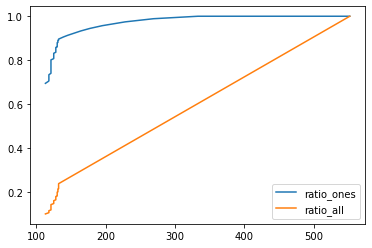

In [10]:
# Plotting the analysis: 

#plt.plot(count_tech_list, ratio_ones_list, label = 'ratio_ones')
#plt.plot(count_tech_list, ratio_all_list, label = 'ratio_all')
#plt.legend()
#plt.show()

### Cutting the data into a training and a test set (80%, 20%)


In [14]:
dfmatrix_reduced

,S0066,S0065,S0469,S0045,S0552,S0331,S0092,S0504,S0584,S0456,...,S0068,S0278,S0283,S0102,S0108,S0385,S0067,S0248,S0350,technique_sum
ID,,,,,,,,,,,,,,,,,,,,,
created,2017-05-31,2017-05-31,2020-06-10,2017-05-31,2020-12-28,2019-01-29,2017-05-31,2020-09-10,2021-03-01,2020-05-26,...,2017-05-31,2018-10-17,2018-10-17,2017-05-31,2017-05-31,2019-06-04,2017-05-31,2018-10-17,2019-01-30,NaN
T1548.002,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,25
T1134,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
T1134.002,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,9
T1134.001,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T1102.002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,24
T1102.001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
T1102.003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [66]:
dfmatrix.sort_values(by = 'created', axis = 1)

# Calculate split column
eightty_split = (dfmatrix.shape[1] * 0.8)
eightty_split = int(np.rint(eightty_split))

x_index = dfmatrix.columns[:eightty_split-1]
y_index = dfmatrix.columns[eightty_split-1:]

X = dfmatrix[x_index].transpose()
Y = dfmatrix[y_index].transpose()
X

ID,created,T1548.002,T1134,T1134.002,T1134.001,T1087.002,T1087.003,T1087.001,T1071,T1071.004,...,T1125,T1497,T1497.001,T1497.003,T1102,T1102.002,T1102.001,T1102.003,T1047,software_sum
S0066,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
S0065,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
S0469,2020-06-10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
S0045,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23.0
S0552,2020-12-28,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0345,2019-01-30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10.0
S0382,2019-05-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.0
S0596,2021-03-23,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,19.0
S0140,2017-05-31,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22.0


In [67]:
X['technique_sum'] = 0
technique_sum = X.drop(['created'], axis = 1).sum(axis = 0)
X.loc['technique_sum'] = technique_sum
X = X.drop('technique_sum', axis = 1)
X

ID,created,T1548.002,T1134,T1134.002,T1134.001,T1087.002,T1087.003,T1087.001,T1071,T1071.004,...,T1125,T1497,T1497.001,T1497.003,T1102,T1102.002,T1102.001,T1102.003,T1047,software_sum
S0066,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
S0065,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
S0469,2020-06-10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
S0045,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23.0
S0552,2020-12-28,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0382,2019-05-29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13.0
S0596,2021-03-23,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,19.0
S0140,2017-05-31,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22.0
S0546,2020-12-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,10.0


In [71]:
# Append propabilities for techniques

X['prop'] = 0
sum_all = technique_sum.drop('software_sum').sum()

X.loc['prop'] = X.loc['technique_sum']/sum_all

X = X.drop('prop', axis = 1)
X

ID,created,T1548.002,T1134,T1134.002,T1134.001,T1087.002,T1087.003,T1087.001,T1071,T1071.004,...,T1125,T1497,T1497.001,T1497.003,T1102,T1102.002,T1102.001,T1102.003,T1047,software_sum
S0066,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
S0065,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.0
S0469,2020-06-10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.0
S0045,2017-05-31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23.0
S0552,2020-12-28,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0596,2021-03-23,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,19.0
S0140,2017-05-31,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22.0
S0546,2020-12-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,10.0
technique_sum,NaN,23,8,8,8,12,4,30,6,22,...,19,10,24,12,8,22,9,4,41,4447.0


In [72]:
# X und Y in Excel speichern

X.to_excel('reduced matrix X.xlsx', sheet_name = 'X')
Y.to_excel('reduced matrix Y.xlsx', sheet_name = 'Y')

In [ ]:
dfmatrix.to_excel('reduced matrix < 4.xlsx', sheet_name = 'reduced matrix')